In [2]:
import numpy as np
import numpy.fft as fft #shorthand for fft.fft2 and fft.fftshift
import poppy #optical simulation library: not as many uses as I hoped, more for telescope simulation
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable #for making nice colorbars

### Notes
The Fresnel Transfer Function (TF) Propagator is given by the equation (CFO 5.2):
$$
H(f_x, f_y) = e^{j k z} \exp[- j \pi \lambda z (f_x^2 + f_y^2)]
$$

In [9]:
def point_distribution(sample_density=100):
    #create a uniform distribution of (sample_density^2) 2D coordinates
    return np.array(np.meshgrid(np.linspace(-1, 1, sample_density), np.linspace(-1, 1, sample_density)))

def fresnel_TF_prop(U1, L, z, wavelength=1):
    # simulate the optical propagation of an input plane based on the Frenel Transfer Function
    #U1: Input image plane, a set of coordinates that will be propagated
    #z: propagation distance
    #L: length of one side of source and observation plane
    sample_density = U1.shape[0]
    freq_dist = 1 / (2* point_distribution(sample_density)) #create frequency sample distribution
    freq_magnitude = np.sum(freq_dist**2, axis=0) 
    TF_arg = -1j * np.pi * wavelength * z * freq_magnitude #argument for the fresnel TF
    H = fft.fftshift(np.exp(TF_arg)) #created shifted transfer function
    U1_fft = fft.fft2(fft.fftshift(U1)) #shift & fft input (source) field
    U2 = fft.ifftshift(fft.ifft2(U1_fft * H)) # output (observed) field obtained by multiplying FFT by H
    return U2

def pupil_func(in_coords, lens_radius = 1):
    return np.sqrt(np.sum(in_coords**2), axis=0) / lens_radius <= 1

def lens_transmittance_fxn(in_coords, wavelength, f):
    #MATLAB examples p96
    k = 2 * np.pi / wavelength
    return pupil_func(in_coords) * np.exp(-1j * k / (2*f) * np.sum(in_coords**2, axis=0))

def focus(im, zf, wavelength=1.):
    #focus(+) or defocus(-) an image with a focal length of +/- zf
    #from MATLAB examples p94
    #uniform_dist = point_distribution()
    focused = im * np.exp((-1j * np.pi / (zf * wavelength)) * np.sum(dist**2, axis=0))
    return focused

#Plotting Functions
def plot_images(im_list, label_list = []):
    num_ims = len(im_list)
    assert(num_ims==len(label_list) or len(label_list)==0)
    fig, ax = plt.subplots(1, num_ims, figsize = (15, 15*num_ims))
    for idx, points in enumerate(im_list):
        divider = make_axes_locatable(ax[idx])
        im = ax[idx].imshow(np.abs(im_list[idx])**2, vmin=0, vmax=1)
        #fig.colorbar(im, cax=cax, orientation='vertical')#, ticks=[0, 0.5, 1.0])
        if idx == num_ims-1:
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')#, ticks=[0, 0.5, 1.0])
    for idx, label in enumerate(label_list):
        ax[idx].set_title(label)
    plt.draw()
        
def plot_im(image, label=""): 
    plt.imshow(np.abs(image)**2, vmin=0, vmax=1)
    plt.colorbar()
    plt.title(label)


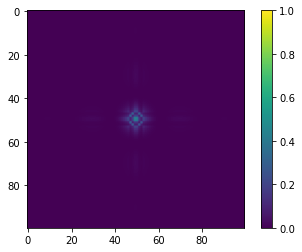

In [18]:
#Gaussian Beam in 2D
dist = np.array(np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)))
gaus = np.exp(-np.sum(dist**2, axis=0)/0.25)
#square beam in 2D
diamond = np.sum(np.abs(dist), axis=0) < 0.5
sq = np.logical_and(abs(dist[1,:,:]) < np.ones_like(dist[1,:,:])*0.5, abs(dist[0,:,:]) < np.ones_like(dist[0,:,:])*0.5)
dot = np.sum(dist**2, axis=0) < 0.003
conv = np.fft.ifft2((np.fft.fft2(diamond) + np.fft.fft2(sq)))


plot_im(focus(fresnel_TF_prop(dot, 2, 0.01),0.1))
#plot_images([gaus, diamond, sq, dot, conv], ["Gaussian", "Diamond", "Square", "Dot",  "Diamond * Square"])


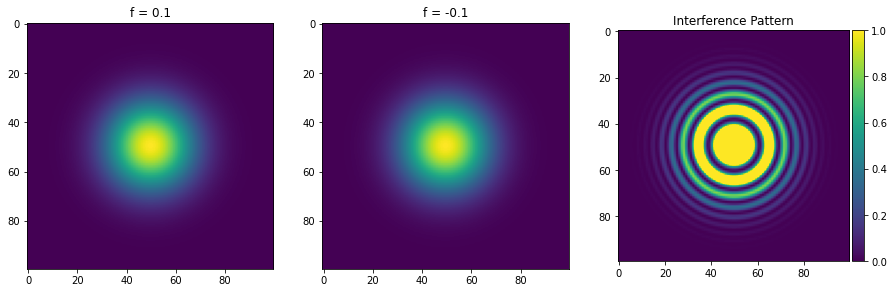

In [70]:
plot_images([focus(gaus, -0.1), focus(gaus, 0.1), (focus(gaus, -0.1) + focus(gaus, 0.1))], ["f = 0.1", "f = -0.1", "Interference Pattern"])

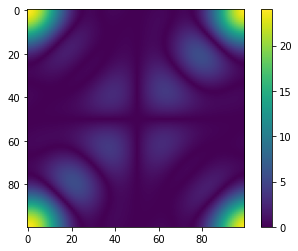

In [37]:
plt.imshow(np.abs(np.real(np.fft.fft2(dot))))
plt.colorbar()

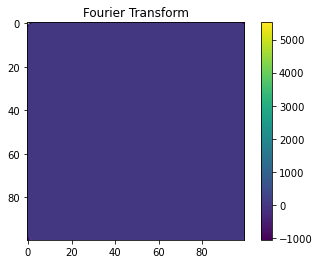

In [41]:
#2D FFT
ft = np.fft.fft2(gaus)
plt.imshow(np.real(ft))
plt.colorbar()
plt.title("Fourier Transform")
plt.draw()

### References
CFO: Computational Fourier Optics: A MATLAB Tutorial